In [1]:
import os
import json
import re
import math
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp

In [2]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [3]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [4]:
def gompertz_growth_rate(t, A, mu, l):
    gr = mu * np.exp(np.exp(1) * mu * (l - t) / A - np.exp(np.exp(1) * mu * (l - t) / A + 1) + 2)
    return gr

In [5]:
def tm_gomp(A, mu, l):
    return A / (mu * np.e) + l

In [6]:
def logistic(t, A, mu, l):
    log_B = A / (1 + np.exp(4 * mu / A * (l - t) + 2))
    return log_B

In [7]:
def logistic_growth_rate(t, A, mu, l):
    gr = 4 * mu * np.exp(4 * mu / A * (l - t) + 2) / (1 + np.exp(4 * mu / A * (l - t) + 2))**2
    return gr

In [8]:
def tm_logistic(A, mu, l):
    return A / (2 * mu) + l

In [12]:
df = pd.read_excel('data_processed.xlsx')

In [13]:
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'Quality', 'exp length', 'Colonies',
       'Centers', 'Radius', 'radj', 'radius', 'area', 'gomp_params',
       'logistic_params', 't_m_gomp', 't_m_logistic', 'r0', 'vel_start',
       'vel_stop', 'vel_fit_start', 'vel_fit_stop', 'mu0', 'ws_params',
       'area_max'],
      dtype='object')

In [14]:
df.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,t_m_gomp,t_m_logistic,r0,vel_start,vel_stop,vel_fit_start,vel_fit_stop,mu0,ws_params,area_max
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,196.234198,225.219567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81704
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,189.071440,215.629207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117407
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,180.609065,205.356638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108474
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,151.439181,174.692595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79025
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,186.954076,211.573857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102832


In [58]:
d = '2023_12_08'
m = 'Tweez scope'
date = datetime.strptime(d, '%Y_%m_%d')
pos = 12

In [59]:
df_exp = df[(df.Date == date) & (df.Machine == m)]
df_exp.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,t_m_gomp,t_m_logistic,r0,vel_start,vel_stop,vel_fit_start,vel_fit_stop,mu0,ws_params,area_max
136,2023-12-08,Tweez scope,0,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,...,182.555028,213.730036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113653
137,2023-12-08,Tweez scope,1,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,...,146.074306,177.726551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103648
138,2023-12-08,Tweez scope,2,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,176.996448,208.380576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120472
139,2023-12-08,Tweez scope,4,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,160.261010,192.633930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132077
140,2023-12-08,Tweez scope,6,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,...,193.557825,230.268648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107045


In [62]:
df_pos = df_exp[df_exp.Position == pos]
df_pos

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,t_m_gomp,t_m_logistic,r0,vel_start,vel_stop,vel_fit_start,vel_fit_stop,mu0,ws_params,area_max
143,2023-12-08,Tweez scope,12,MC4100,pLPT20&pLPT41,ATC-,3,10^(-5),14:18:00,19:07:00,...,187.726002,214.874649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180812


In [97]:
gparams = json.loads(df_pos['gomp_params'].values[0])
lparams = json.loads(df_pos['logistic_params'].values[0])

In [92]:
gA = gparams['A']
gmu = gparams['mu_m']
gl = gparams['lambda']
lA = lparams['A']
lmu = lparams['mu_m']
ll = lparams['lambda']

##### Incubation time

In [104]:
idx = df_pos.index
area = extract_array(df.loc[idx,'area'].values[0])
incub_time_s = datetime.strptime(df.loc[143,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[143,'t_incub'], '%H:%M:%S')
incub_time_n = incub_time_s.seconds / 60
t = np.arange(0, df.loc[143, 'exp length'])*10 + incub_time_n

In [109]:
np.arange(0,t[-1])

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.336e+03, 4.337e+03,
       4.338e+03])

In [94]:
gg = gompertz(np.arange(0,t[-1]),gA,gmu,gl)
lg = logistic(np.arange(0,t[-1]),lA,lmu,ll)

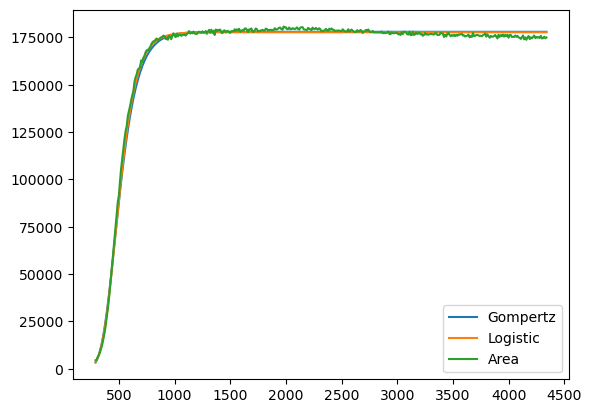

In [107]:
plt.plot(np.arange(0,t[-1]),np.exp(gg), label='Gompertz')
plt.plot(np.arange(0,t[-1]),np.exp(lg), label='Logistic')
plt.plot(t,area, label='Area')
plt.legend()
plt.show()